In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_dir = '/content/drive/My Drive/sample-fruits-360'

In [3]:
# Import libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split

In [4]:
# Function for load images
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files, targets, target_labels

In [5]:
# Load Dataset
x, y, target_labels = load_dataset(data_dir)
print("Dataset Loaded !")

# Get Trainning size and Test size 
print('Total set size : ',x.shape)
print('Total targets : ',len(target_labels) )

Dataset Loaded !
Total set size :  (1095,)
Total targets :  73


In [6]:
# Function for convert image to array
def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        images_as_array.append(keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(file)))
    return images_as_array

# Convert images to numpy array using keras.preprocessing library
x = np.array(convert_image_to_array(x),np.float32)
print(x.shape)

(1095, 100, 100, 3)


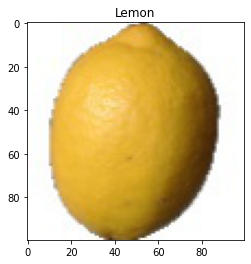

In [7]:
# Plot image on random data
plt.imshow(x[1]/255)
plt.title(target_labels[y[1]])
plt.show()

In [8]:
# Flatten the features of image
x = x.reshape([-1,100*100*3])
x = x/255
print("final shape : " , x.shape)

final shape :  (1095, 30000)


In [9]:
# Train and Test split
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=74)

# Get size of all set
print("X Train size : ", X_train.shape)
print("X Test size : ", X_test.shape)
print("Y Train size : ", y_train.shape)
print("Y Test size : ", y_test.shape)

X Train size :  (876, 30000)
X Test size :  (219, 30000)
Y Train size :  (876,)
Y Test size :  (219,)


In [10]:
# Convert numpy array to torch
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

In [11]:
# Define no of iteration, batch size, num_epochs
batch_size=100
n_iters = 1000
num_epochs = n_iters / (len(X_train) / batch_size)
num_epochs = int(num_epochs)

In [12]:
# Set train and test
train = torch.utils.data.TensorDataset(X_train,y_train)
test = torch.utils.data.TensorDataset(X_test,y_test)
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

### CNN with 2 convolutional layer and 1 fully connected layer

In [13]:
# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1,padding=0)
        self.relu1 = nn.ReLU()

        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1,padding=0)
        self.relu2 = nn.ReLU()

        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(15488,len(target_labels));
        
    def forward(self,x):
        
        out=self.cnn1(x)
        out=self.relu1(out)
        out=self.maxpool1(out)
    
        out=self.cnn2(out)
        out=self.relu2(out)
        out=self.maxpool2(out)
        
        out = out.view(out.size(0), -1)
        out=self.fc1(out)
        
        return out

In [14]:
# Initialize Parameters and fit the model
model = CNNModel()
error = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        train = Variable(images.view(-1,3,100,100))
        #print(train.shape)
        labels = Variable(labels)
        optimizer.zero_grad()
        outputs = model(train)
        loss = error(outputs, labels)
        loss.backward()      
        optimizer.step()      
        count += 1
        
        if count % 50 == 0:         
            correct = 0
            total = 0
            for images, labels in test_loader:
                test = Variable(images.view(-1,3,100,100))
                outputs = model(test)
                predicted = torch.max(outputs.data, 1)[1]
                total += len(labels)
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / float(total)
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 5 == 0:
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 50  Loss: 4.275338649749756  Accuracy: 2.7397260665893555 %
Iteration: 100  Loss: 4.289216995239258  Accuracy: 0.456620991230011 %
Iteration: 150  Loss: 4.325140476226807  Accuracy: 0.913241982460022 %
Iteration: 200  Loss: 4.286386013031006  Accuracy: 0.456620991230011 %
Iteration: 250  Loss: 3.63972806930542  Accuracy: 18.721460342407227 %
Iteration: 300  Loss: 3.7585675716400146  Accuracy: 25.570775985717773 %
Iteration: 350  Loss: 3.8496618270874023  Accuracy: 13.698630332946777 %
Iteration: 400  Loss: 0.3587438464164734  Accuracy: 94.52054595947266 %
Iteration: 450  Loss: 0.03490452095866203  Accuracy: 98.17351531982422 %
Iteration: 500  Loss: 0.004759675357490778  Accuracy: 99.08676147460938 %
Iteration: 550  Loss: 0.003552044276148081  Accuracy: 99.08676147460938 %
Iteration: 600  Loss: 0.0022787991911172867  Accuracy: 99.54338073730469 %
Iteration: 650  Loss: 0.0014323372161015868  Accuracy: 99.54338073730469 %
Iteration: 700  Loss: 0.005599956959486008  Accuracy: 99

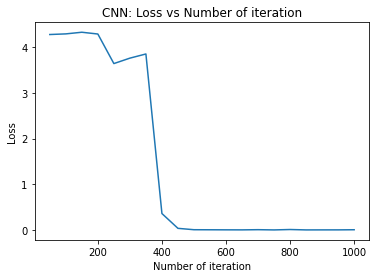

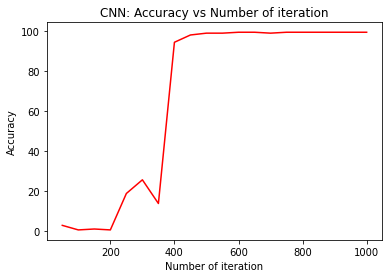

In [16]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

### CNN with 3 convolutional layer and 1 fully connected layer

In [17]:
# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1,padding=0)
        self.relu1 = nn.ReLU()

        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1,padding=0)
        self.relu2 = nn.ReLU()

        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.cnn3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,stride=1,padding=0)
        self.relu3 = nn.ReLU()

        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
         
        self.fc1 = nn.Linear(5184,len(target_labels));
        
    def forward(self,x):
        
        out=self.cnn1(x)
        out=self.relu1(out)
        out=self.maxpool1(out)
    
        out=self.cnn2(out)
        out=self.relu2(out)
        out=self.maxpool2(out)
        
        out=self.cnn3(out)
        out=self.relu3(out)
        out=self.maxpool3(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        
        return out

In [18]:
# Initialize Parameters and fit the model
model = CNNModel()
error = nn.CrossEntropyLoss()
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [19]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        train = Variable(images.view(-1,3,100,100))
        labels = Variable(labels)
        optimizer.zero_grad()
        outputs = model(train)
        loss = error(outputs, labels)
        loss.backward()      
        optimizer.step()      
        count += 1
        
        if count % 50 == 0:         
            correct = 0
            total = 0
            for images, labels in test_loader:
                test = Variable(images.view(-1,3,100,100))
                outputs = model(test)
                predicted = torch.max(outputs.data, 1)[1]
                total += len(labels)
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / float(total)
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 5 == 0:
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 50  Loss: 4.2426676750183105  Accuracy: 0.0 %
Iteration: 100  Loss: 4.137964248657227  Accuracy: 5.022830963134766 %
Iteration: 150  Loss: 2.5207266807556152  Accuracy: 51.14155197143555 %
Iteration: 200  Loss: 0.8878799676895142  Accuracy: 85.38813018798828 %
Iteration: 250  Loss: 0.16059371829032898  Accuracy: 97.2602767944336 %
Iteration: 300  Loss: 0.14908604323863983  Accuracy: 97.2602767944336 %
Iteration: 350  Loss: 0.0743330642580986  Accuracy: 98.63013458251953 %
Iteration: 400  Loss: 0.019346822053194046  Accuracy: 99.54338073730469 %
Iteration: 450  Loss: 0.1324983835220337  Accuracy: 100.0 %
Iteration: 500  Loss: 0.010032325983047485  Accuracy: 99.54338073730469 %
Iteration: 550  Loss: 0.006634755525738001  Accuracy: 100.0 %
Iteration: 600  Loss: 0.0030088969506323338  Accuracy: 100.0 %
Iteration: 650  Loss: 0.0032461590599268675  Accuracy: 99.54338073730469 %
Iteration: 700  Loss: 0.007285582832992077  Accuracy: 99.54338073730469 %
Iteration: 750  Loss: 0.007793

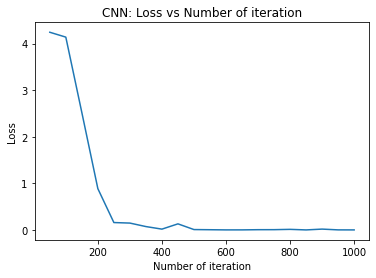

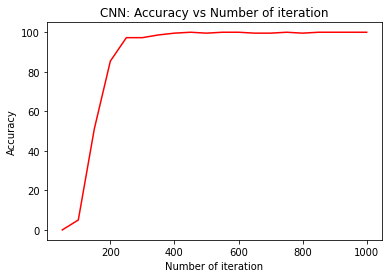

In [20]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

#### As we can see from above two model , if first I take 2 convolutional layer and 1 full connected layer with learning rate 0.1, next I take 3 convolutional layer and 1 fully connected layer with learning rate 0.02, keeping all parameters same I get good performance but If I take other learning rate with different numbers of convolutinal layer and fully connected layer then I get bad performance or underfitting model.